## Arboles
El objetivo de este notebook es implementar el algoritmo de arboles. Los arboles puedes ser tuilizados para prediccion y para clasificacion. Como Miguel lo explico, existen diferentes medidas para realizar la seleccion de la variable de un arbol.

Para iniciar vamos a trabajar con datos categoricos:

$H_{(S)} = \sum_{i=1}^{C}{-p_i  \log_2{p_i}}$

$H_{(T,X)} = \sum_{c \in{X}}{p_{(c)}{H_{(c)}} }$

$Gain_{(T,X)} = H_{(T)} - H_{(T,X)}$


Algunos links the referencia.
* [saedsayad](https://www.saedsayad.com/decision_tree.htm)
* [xoriant](https://www.xoriant.com/blog/product-engineering/decision-trees-machine-learning-algorithm.html)

In [13]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib
from sklearn import datasets
from networkx.drawing.nx_agraph import graphviz_layout
%matplotlib inline

In [2]:
iris = datasets.load_iris()

In [3]:
df_x = pd.DataFrame(iris['data'], columns=iris.feature_names )
df_x.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [41]:
df_trans = df_x.apply(lambda x: pd.qcut(x,6, False),axis=0)
y = iris['target']
df_trans.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,1,5,0,0
1,0,2,0,0
2,0,3,0,0
3,0,3,0,0
4,0,5,0,0


In [87]:
class Tree():
        
    def __init__(self, stop=4, verbose=False, col_names=None):
        self.G = nx.DiGraph()
        self.verbose = verbose
        self.col_names = col_names
        self.stop = stop
        
    def train(self,X,y):
        def create_mask(r_ix_aux, r_ix):
            t = 0
            for ix,ix_val in enumerate(r_ix_aux):
                if ix_val:
                    r_ix_aux[ix] = r_ix[t]
                    t += 1
                else:
                    r_ix_aux[ix] = False
            return r_ix_aux
        
        X_aux = X.copy()
        y_aux = y.copy()
        w_queue = []
        c_ix,h_val,g_val = self.calculate_gain(X,y)
        node_prev = self.get_name(c_ix)
        self.G.add_node(node_prev)
        uniques, counts = np.unique(X_aux[:,c_ix], return_counts=True)
        r_ix = [True]*X.shape[0]
        w_queue.extend([(c_ix,r_ix.copy(),ele,node_prev,) for ele in uniques])
        while len(w_queue)>0:
            c_ix, r_ix, ele, node_prev = w_queue.pop(0)
            r_ix_aux = r_ix
            r_ix = np.array(np.equal(X[r_ix,c_ix],[ele]))
            r_ix = create_mask(r_ix_aux, r_ix)
            c_ix,h_val,g_val = self.calculate_gain(X_aux[r_ix,:]
                                           ,y_aux[r_ix])
            print('control', c_ix,g_val,sum(g_val),len(w_queue) )
            if sum(h_val) > 0 and sum(g_val) > 0 :
                node_cur = self.get_name(c_ix)
                self.G.add_node(node_cur)
                self.G.add_edge(node_prev,
                                node_cur,
                                attr_dict={"name":ele,"col":c_ix})
                uniques, counts = np.unique(X_aux[r_ix,c_ix], return_counts=True)
                w_queue.extend([(c_ix,r_ix.copy(),ele,node_cur) for ele in uniques])

            if sum(h_val) == 0.0 :
                uniques, counts = np.unique(y_aux[r_ix],
                                            return_counts=True)
                for unique,count in zip(uniques,counts):
                    final_node = node_prev+"-"+str(unique)
                    self.G.add_node(final_node)
                    self.G.add_edge(node_prev,
                                    final_node,
                                    attr_dict={"name":ele,"col":count})
        
    def calculate_gain(self, X,y):
        """Calcula la ganancia"""
        ini_h = self.entropy(y)
        if len(X.shape)==1:
            X = X.reshape(-1,1)
        n = X.shape[1]
        t_gain = []
        t_entropy = []
        for ix in range(n):
            h_Xy = self.entropy_2v(X[:,ix],y)
            t_gain.append(ini_h-h_Xy)
            t_entropy.append(h_Xy)
        ix_sel = np.argmax(t_gain)
        return ix_sel, t_entropy, t_gain
        
    def entropy(self, y):
        n = np.array(y).shape[0]
        unique, counts = np.unique(y, return_counts=True)
        f_plog = lambda x : -x*math.log(x,2)
        h = sum( [f_plog(c*1.0/n) for c in counts])
        if self.verbose:
            msj = "Num {0} Counts{1} Entropy {2:.02f}"
            print (msj.format(unique, counts, h))   
        return h
    
    def entropy_2v(self,x,y):
        n = np.array(x).shape[0]
        uniques, counts = np.unique(x, return_counts=True)
        h_st = 0
        for unique, counts in zip(uniques, counts):
            prob_c = counts*1.0/n
            ix = np.array(np.equal(x, [unique]))
            h_st += prob_c * self.entropy(y[ix])
            if self.verbose:
                msj = "Prob {0:.02f} Entropy {0:.02f}"
                print (msj.format(prob_c, self.entropy(y[ix])) )
        return h_st
    
    def predict():
        pass

    def get_name(self,ix):
            return self.col_names[ix] if self.col_names is not None else str(ix)      
        


In [88]:
m_tree = Tree(verbose=True, col_names=df_trans.columns.values)
m_tree.train(df_trans.values, y)

Num [0 1 2] Counts[50 50 50] Entropy 1.58
Num [0 1 2] Counts[28  3  1] Entropy 0.64
Num [0 1 2] Counts[28  3  1] Entropy 0.64
Prob 0.21 Entropy 0.21
Num [0 1] Counts[17  3] Entropy 0.61
Num [0 1] Counts[17  3] Entropy 0.61
Prob 0.13 Entropy 0.13
Num [0 1 2] Counts[ 5 18  5] Entropy 1.30
Num [0 1 2] Counts[ 5 18  5] Entropy 1.30
Prob 0.19 Entropy 0.19
Num [1 2] Counts[15 13] Entropy 1.00
Num [1 2] Counts[15 13] Entropy 1.00
Prob 0.19 Entropy 0.19
Num [1 2] Counts[ 8 14] Entropy 0.95
Num [1 2] Counts[ 8 14] Entropy 0.95
Prob 0.15 Entropy 0.15
Num [1 2] Counts[ 3 17] Entropy 0.61
Num [1 2] Counts[ 3 17] Entropy 0.61
Prob 0.13 Entropy 0.13
Num [0 1 2] Counts[ 1 21 11] Entropy 1.10
Num [0 1 2] Counts[ 1 21 11] Entropy 1.10
Prob 0.22 Entropy 0.22
Num [0 1 2] Counts[ 1 13 10] Entropy 1.20
Num [0 1 2] Counts[ 1 13 10] Entropy 1.20
Prob 0.16 Entropy 0.16
Num [0 1 2] Counts[ 6  8 12] Entropy 1.53
Num [0 1 2] Counts[ 6  8 12] Entropy 1.53
Prob 0.17 Entropy 0.17
Num [0 1 2] Counts[10  6  9] Entrop

Num [2] Counts[2] Entropy 0.00
Prob 0.33 Entropy 0.33
Num [2] Counts[4] Entropy 0.00
Num [2] Counts[4] Entropy 0.00
Prob 0.67 Entropy 0.67
Num [2] Counts[6] Entropy 0.00
Num [2] Counts[6] Entropy 0.00
Prob 1.00 Entropy 1.00
control 0 [0.0, 0.0, 0.0, 0.0] 0.0 5
Num [1 2] Counts[1 5] Entropy 0.65
Num [2] Counts[3] Entropy 0.00
Num [2] Counts[3] Entropy 0.00
Prob 0.50 Entropy 0.50
Num [1 2] Counts[1 2] Entropy 0.92
Num [1 2] Counts[1 2] Entropy 0.92
Prob 0.50 Entropy 0.50
Num [1 2] Counts[1 5] Entropy 0.65
Num [1 2] Counts[1 5] Entropy 0.65
Prob 1.00 Entropy 1.00
Num [2] Counts[2] Entropy 0.00
Num [2] Counts[2] Entropy 0.00
Prob 0.33 Entropy 0.33
Num [1 2] Counts[1 3] Entropy 0.81
Num [1 2] Counts[1 3] Entropy 0.81
Prob 0.67 Entropy 0.67
Num [1 2] Counts[1 5] Entropy 0.65
Num [1 2] Counts[1 5] Entropy 0.65
Prob 1.00 Entropy 1.00
control 0 [0.19087450462110933, 0.0, 0.10917033867559889, 0.0] 0.3000448432967082 4
Num [1 2] Counts[1 3] Entropy 0.81
Num [1] Counts[1] Entropy 0.00
Num [1] Coun

In [89]:
data = [["D1","Sunny","Hot","High","Weak","No"],
["D2","Sunny","Hot","High","Strong","No"],
["D3","Overcast","Hot","High","Weak","Yes"],
["D4","Rain","Mild","High","Weak","Yes"],
["D5","Rain","Cool","Normal","Weak","Yes"],
["D6","Rain","Cool","Normal","Strong","No"],
["D7","Overcast","Cool","Normal","Strong","Yes"],
["D8","Sunny","Mild","High","Weak","No"],
["D9","Sunny","Cool","Normal","Weak","Yes"],
["D10","Rain","Mild","Normal","Weak","Yes"],
["D11","Sunny","Mild","Normal","Strong","Yes"],
["D12","Overcast","Mild","High","Strong","Yes"],
["D13","Overcast","Hot","Normal","Weak","Yes"],
["D14","Rain","Mild","High","Strong","No"]]
columns=["Day","Outlook","Temperature","Humidity","Wind","Play Golf"]
df_golf = pd.DataFrame(data,columns=columns )

m_tree = Tree(verbose=True,col_names=columns[1:5] )
m_tree.train(df_golf.iloc[:,1:5].values,df_golf.iloc[:,-1].values)
#m_tree.entropy_2v(df_golf.iloc[:,4],df_golf.iloc[:,-1].values)

Num ['No' 'Yes'] Counts[5 9] Entropy 0.94
Num ['Yes'] Counts[4] Entropy 0.00
Num ['Yes'] Counts[4] Entropy 0.00
Prob 0.29 Entropy 0.29
Num ['No' 'Yes'] Counts[2 3] Entropy 0.97
Num ['No' 'Yes'] Counts[2 3] Entropy 0.97
Prob 0.36 Entropy 0.36
Num ['No' 'Yes'] Counts[3 2] Entropy 0.97
Num ['No' 'Yes'] Counts[3 2] Entropy 0.97
Prob 0.36 Entropy 0.36
Num ['No' 'Yes'] Counts[1 3] Entropy 0.81
Num ['No' 'Yes'] Counts[1 3] Entropy 0.81
Prob 0.29 Entropy 0.29
Num ['No' 'Yes'] Counts[2 2] Entropy 1.00
Num ['No' 'Yes'] Counts[2 2] Entropy 1.00
Prob 0.29 Entropy 0.29
Num ['No' 'Yes'] Counts[2 4] Entropy 0.92
Num ['No' 'Yes'] Counts[2 4] Entropy 0.92
Prob 0.43 Entropy 0.43
Num ['No' 'Yes'] Counts[4 3] Entropy 0.99
Num ['No' 'Yes'] Counts[4 3] Entropy 0.99
Prob 0.50 Entropy 0.50
Num ['No' 'Yes'] Counts[1 6] Entropy 0.59
Num ['No' 'Yes'] Counts[1 6] Entropy 0.59
Prob 0.50 Entropy 0.50
Num ['No' 'Yes'] Counts[3 3] Entropy 1.00
Num ['No' 'Yes'] Counts[3 3] Entropy 1.00
Prob 0.43 Entropy 0.43
Num ['No'

In [90]:
edges_n = {(u,v):m_tree.G.get_edge_data(u,v)['attr_dict']['name']
           for u,v in m_tree.G.edges()}
edges_n

{('Outlook', 'Outlook-Yes'): 'Overcast',
 ('Outlook', 'Wind'): 'Rain',
 ('Outlook', 'Humidity'): 'Sunny',
 ('Wind', 'Wind-No'): 'Strong',
 ('Wind', 'Wind-Yes'): 'Weak',
 ('Humidity', 'Humidity-No'): 'High',
 ('Humidity', 'Humidity-Yes'): 'Normal'}

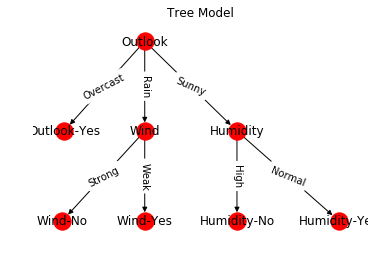

In [91]:
plt.title('Tree Model')
pos = graphviz_layout(m_tree.G, prog='dot')
edges_n = {(u,v):m_tree.G.get_edge_data(u,v)['attr_dict']['name']
           for u,v in m_tree.G.edges()}
nx.draw_networkx_edge_labels(m_tree.G,pos,edge_labels=edges_n)
nx.draw(m_tree.G, pos, with_labels=True, arrows=True)
plt.show()

In [30]:
import graphviz
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree 
clf = tree.DecisionTreeClassifier(random_state=0,criterion='entropy')
clf.fit(df_trans, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

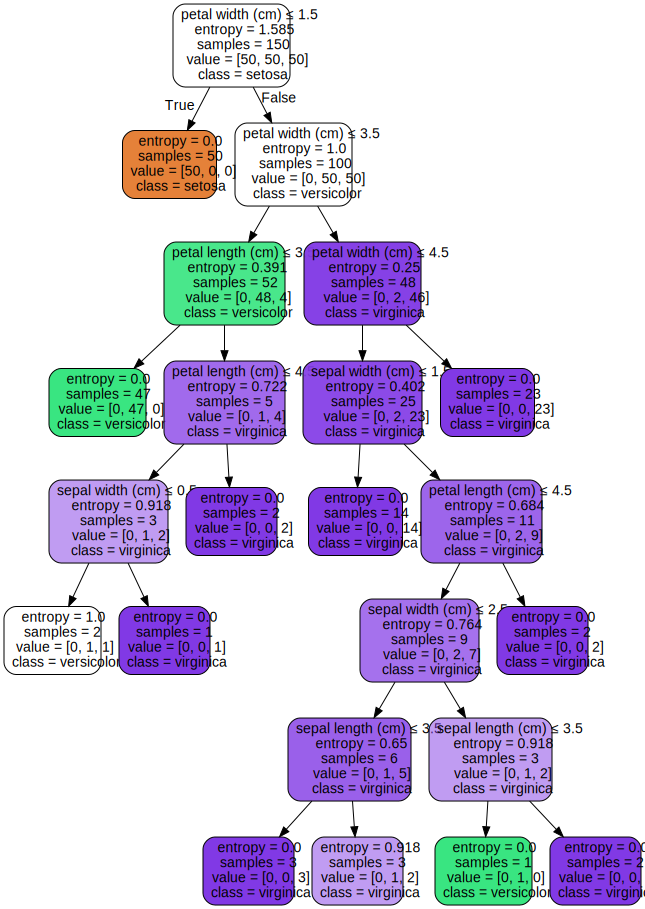

In [31]:

dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 